In [1]:
import pandas as pd
import numpy as np
import os, re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
files = list(filter(
    lambda x: '.feather' in x,
    os.listdir()))

In [3]:
data = {f: pd.read_feather(f).set_index('Unnamed: 0') for f in tqdm(files) if '.feather' in f}

100%|██████████| 74/74 [00:47<00:00,  1.55it/s]


In [29]:
for f, df in tqdm(data.items()):
    df['singular_grammaticality'] = df.candidate2_base_prob / df.candidate1_base_prob
    df['plural_grammaticality']   = df.candidate1_alt1_prob / df.candidate2_alt1_prob
    df['inv_singular_grammaticality'] = 1 / df.singular_grammaticality
    df['inv_plural_grammaticality']   = 1 / df.plural_grammaticality
    df['yz'] = df.candidate2_prob / df.candidate1_prob
    df['effect'] = df.yz / df.singular_grammaticality - 1
    df['total_effect'] = 1 / (df.plural_grammaticality * df.singular_grammaticality) - 1

100%|██████████| 74/74 [01:43<00:00,  1.40s/it]


In [31]:
data_agg  = {}
data_top5 = {}
cols = [
    'neuron', 'layer', 
    'effect', 
    'singular_grammaticality', 'plural_grammaticality', 
    'inv_singular_grammaticality', 'inv_plural_grammaticality',
    'total_effect',
]
for f, df in tqdm(data.items()):
    agg = (
        df[cols].groupby(['layer', 'neuron'])
        .agg(['mean', 'std', 'sem']))
    agg.columns = ['_'.join(col) for col in agg.columns]
    data_agg[f] = agg
    data_top5[f] = (
        agg.sort_values('effect_mean')      # Sort
        .groupby('layer')                   # Get layers
        .tail(int(agg.index.max()[1]*0.05)) # Take top 5%
        .index)                             # Get indices of top 5% by layer

100%|██████████| 74/74 [03:51<00:00,  3.13s/it]


In [32]:
data_agg[f]

effect_mean  effect_std  effect_sem  \
layer neuron                                        
0     0         -0.000173    0.001704    0.000121   
      1          0.000122    0.002817    0.000199   
      2          0.000187    0.001270    0.000090   
      3          0.000686    0.001806    0.000128   
      4         -0.000082    0.003413    0.000241   
...                   ...         ...         ...   
48    1595      -0.000101    0.001203    0.000085   
      1596      -0.000180    0.002188    0.000155   
      1597       0.003047    0.005648    0.000399   
      1598      -0.001251    0.002823    0.000200   
      1599      -0.000179    0.001395    0.000099   

              singular_grammaticality_mean  singular_grammaticality_std  \
layer neuron                                                              
0     0                           0.136953                     0.300352   
      1                           0.136953                     0.300352   
      2                           0.136953                     0.300352   
      3                           0.136953                     0.300352   
      4                           0.136953                     0.300352   
...                                    ...                          ...   
48    1595                        0.136953                     0.300352   
      1596                        0.136953                     0.300352   
      1597                        0.136953                     0.300352   
      1598                        0.136953                     0.300352   
      1599                        0.136953                     0.300352   

              singular_grammaticality_sem  plural_grammaticality_mean  \
layer neuron                                                            
0     0                          0.021238                    0.010118   
      1                          0.021238                    0.010118   
      2                          0.021238                    0.010118   
      3                          0.021238                    0.010118   
      4                          0.021238                    0.010118   
...                                   ...                         ...   
48    1595                       0.021238                    0.010118   
      1596                       0.021238                    0.010118   
      1597                       0.021238                    0.010118   
      1598                       0.021238                    0.010118   
      1599                       0.021238                    0.010118   

              plural_grammaticality_std  plural_grammaticality_sem  \
layer neuron                                                         
0     0                        0.012618                   0.000892   
      1                        0.012618                   0.000892   
      2                        0.012618                   0.000892   
      3                        0.012618                   0.000892   
      4                        0.012618                   0.000892   
...                                 ...                        ...   
48    1595                     0.012618                   0.000892   
      1596                     0.012618                   0.000892   
      1597                     0.012618                   0.000892   
      1598                     0.012618                   0.000892   
      1599                     0.012618                   0.000892   

              inv_singular_grammaticality_mean  \
layer neuron                                     
0     0                              27.819726   
      1                              27.819726   
      2                              27.819726   
      3                              27.819726   
      4                              27.819726   
...                                        ...   
48    1595                           27.819726   
      1596                           

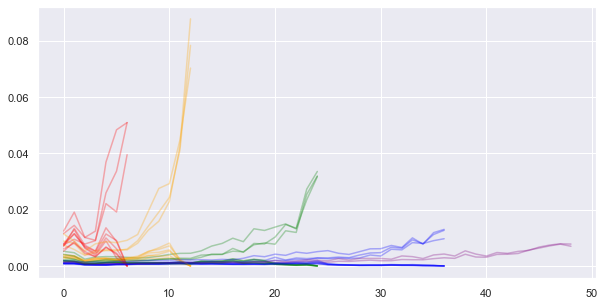

In [81]:
plt.figure(figsize=(10,5))
for f in filter(lambda x: 'indirect' in x, data_agg):
    if 'distil' in f:
        color = 'red'
    elif 'medium' in f:
        color = 'green'
    elif 'large' in f:
        color = 'blue'
    elif 'xl' in f:
        color = 'purple'
    else:
        color = 'orange'
    df = data_agg[f]
    idx = data_top5[f]
    effects = (
        df.loc[idx]
        .sort_values('layer')
        .reset_index()
        .groupby('layer')
        .mean().effect_mean
    )
    plt.plot(
        effects,
        label=f[:-8].replace('_',' '), alpha=0.3, color=color,
    )
# plt.legend()
plt.show()

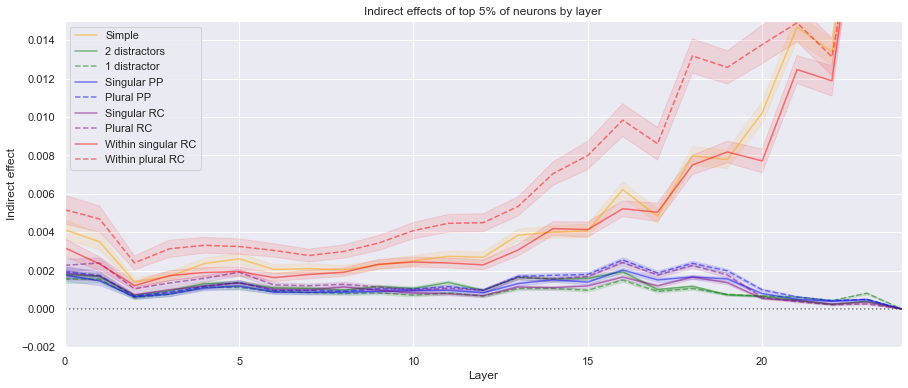

In [82]:
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_indirect_gpt2-medium.feather',   'green', '2 distractors', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'green', '1 distractor',  '--'),
    ('singular_indirect_gpt2-medium.feather',     'blue',  'Singular PP',   '-'),
    ('plural_indirect_gpt2-medium.feather',       'blue',  'Plural PP',     '--'),
    ('_'.join(['rc_singular', 'indirect', 'gpt2-medium.feather']), 'purple', 'Singular RC', '-'),
    ('_'.join(['rc_plural',   'indirect', 'gpt2-medium.feather']), 'purple', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular', 'indirect', 'gpt2-medium.feather']), 'red', 'Within singular RC', '-'),
    ('_'.join(['within_rc_plural',   'indirect', 'gpt2-medium.feather']), 'red', 'Within plural RC',   '--'),
]
    
plt.figure(figsize=(15,6))
for f, color, label, linestyle in lines:
    df = data_agg[f].loc[data_top5[f]].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    plt.plot(
        df.layer.unique(), 
        effect_mean,
        label=label, color=color, linestyle=linestyle, alpha=0.5,
    )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
plt.legend()
plt.title('Indirect effects of top 5% of neurons by layer')
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
plt.ylim([-0.002, 0.015])
plt.hlines(0, 0, 24, color='black', alpha=0.5, linestyle='dotted')
plt.xlim([0,24])
plt.savefig('../top5.png')
plt.show()

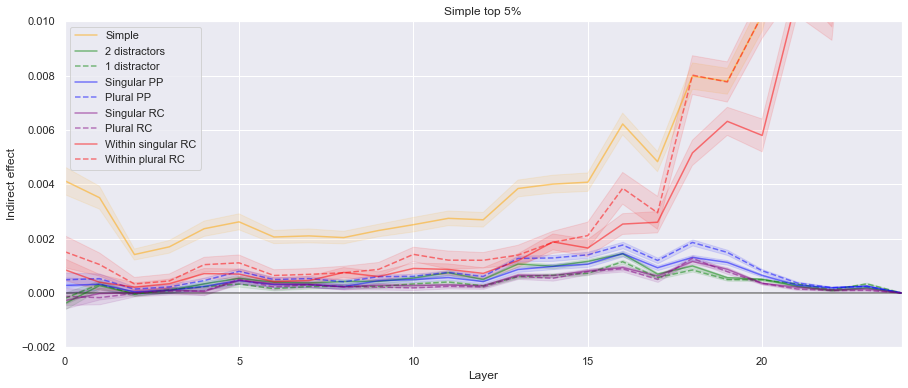

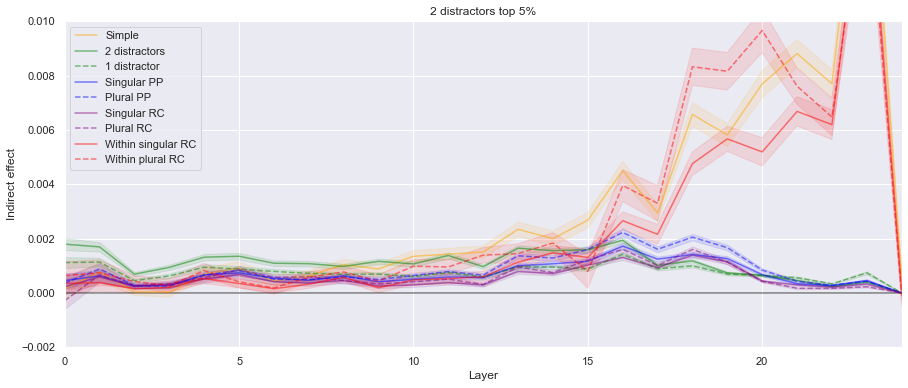

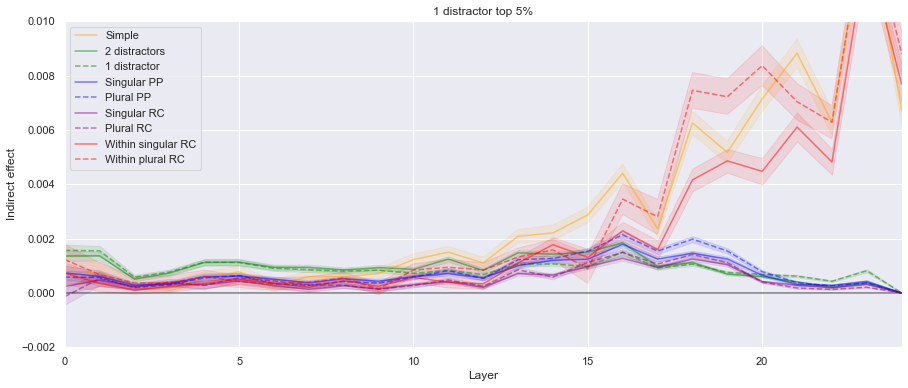

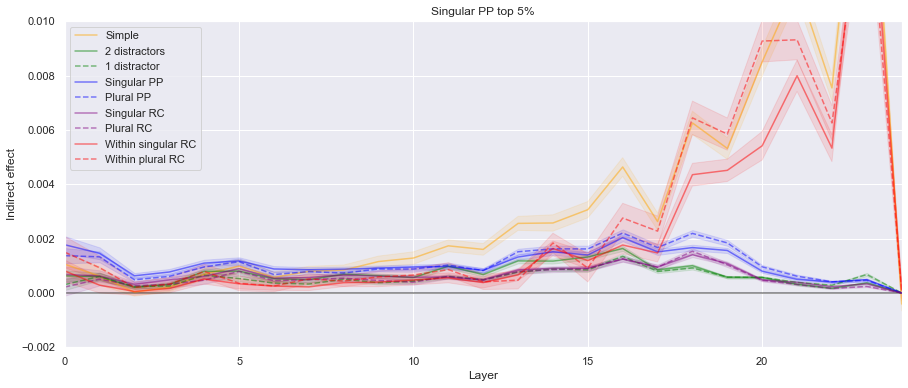

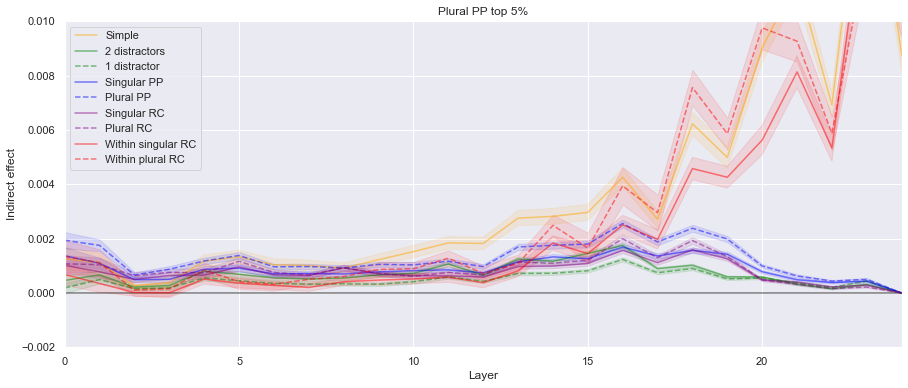

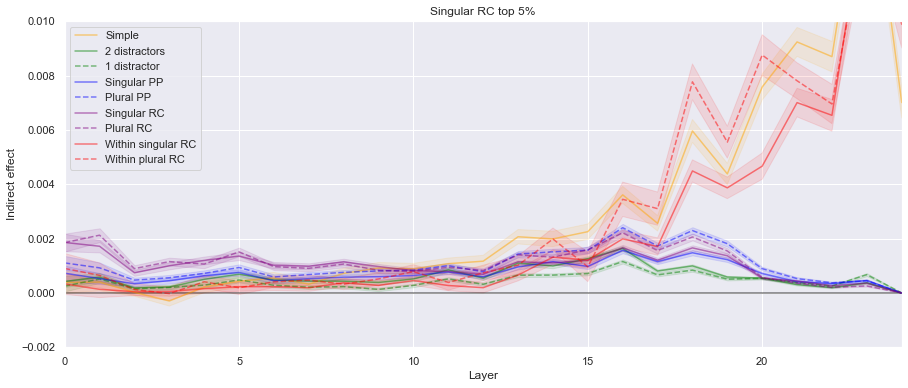

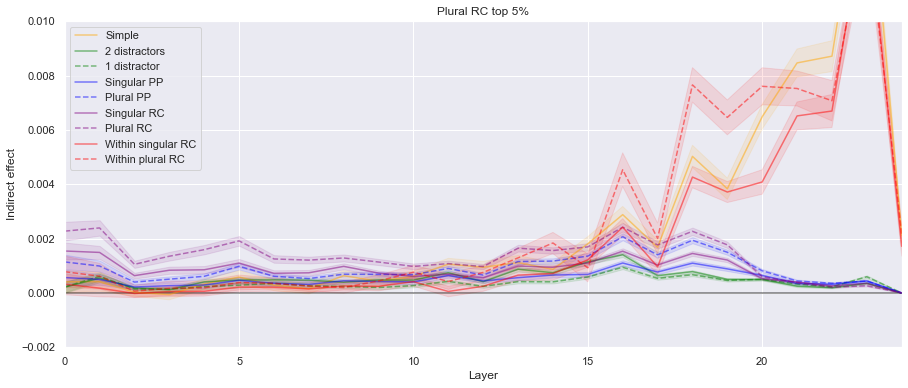

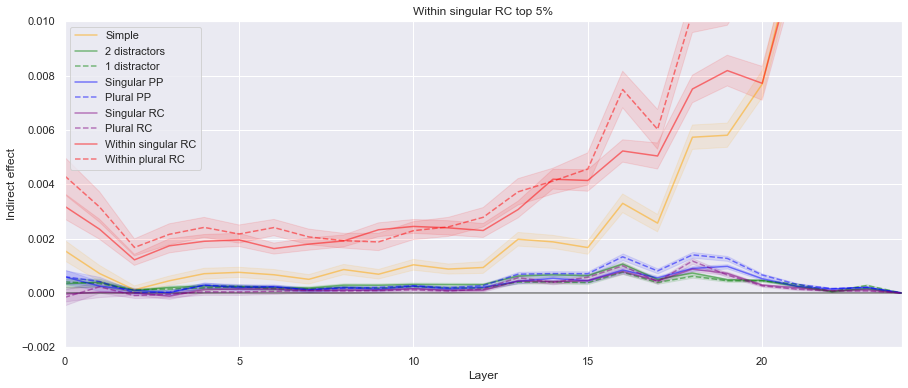

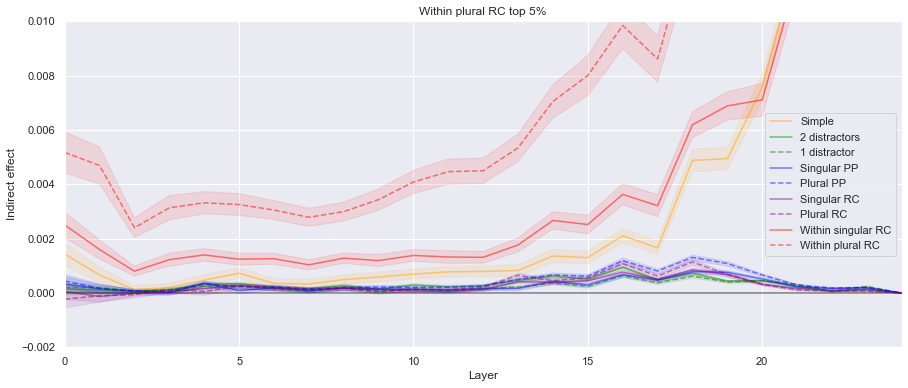

In [56]:
for g, _, title, _ in lines:
    plt.figure(figsize=(15,6))
    for f, color, label, linestyle in lines:
        df = data_agg[f].loc[data_top5[g]].sort_values('layer').reset_index()
        effect_mean = df.groupby('layer').mean().effect_mean
        effect_std = df.groupby('layer').mean().effect_sem
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
        )
        plt.fill_between(
            df.layer.unique(),
            effect_mean + effect_std,
            effect_mean - effect_std,
            alpha=0.1, color=color
        )
    plt.title(title + ' top 5%')
    plt.legend()
    plt.hlines(0, 0, 24, color='black', alpha=0.5)
    plt.xlim([0,24])
    plt.xlabel('Layer')
    plt.ylabel('Indirect effect')
    plt.ylim([-0.002, 0.01])
    plt.savefig('../top5.png')
    plt.show()

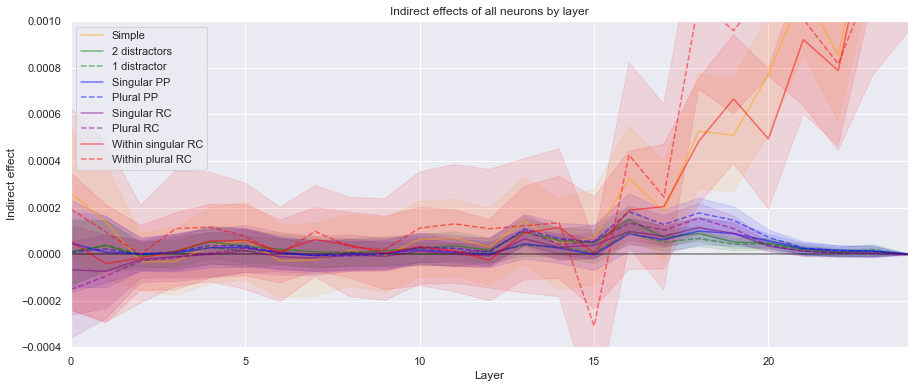

In [83]:
plt.figure(figsize=(15,6))
for f, color, label, linestyle in lines:
    df = data_agg[f].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    plt.plot(
        df.layer.unique(), 
        effect_mean,
        label=label, color=color, linestyle=linestyle, alpha=0.5,
    )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
plt.legend()
plt.title('Indirect effects of all neurons by layer')
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
plt.ylim([-0.0004, 0.001])
plt.hlines(0, 0, 24, color='black', alpha=0.5)
plt.xlim([0,24])
plt.savefig('../top5.png')
plt.show()

In [36]:
data_agg[f].iloc[200]

effect_mean                            0.002704
effect_std                             0.005717
effect_sem                             0.000404
singular_grammaticality_mean           0.274619
singular_grammaticality_std            0.335955
singular_grammaticality_sem            0.023756
plural_grammaticality_mean             0.007932
plural_grammaticality_std              0.009146
plural_grammaticality_sem              0.000647
inv_singular_grammaticality_mean      13.498625
inv_singular_grammaticality_std       19.987312
inv_singular_grammaticality_sem        1.413316
inv_plural_grammaticality_mean       327.674767
inv_plural_grammaticality_std        395.512022
inv_plural_grammaticality_sem         27.966923
total_effect_mean                   3049.525111
total_effect_std                    6072.701853
total_effect_sem                     429.404866
Name: (0, 200), dtype: float64

100%|██████████| 9/9 [00:00<00:00, 3634.58it/s]


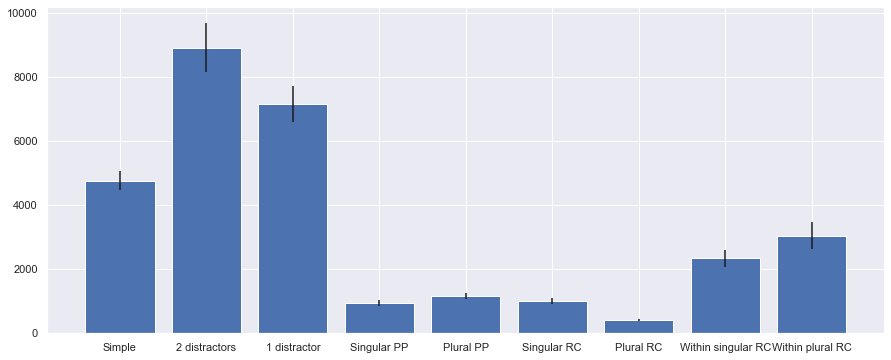

In [37]:
plt.figure(figsize=(15,6))
labels = []
bars   = []
errors = []
for f, color, label, linestyle in tqdm(lines):
    labels.append(label)
    bars.append  (data_agg[f].iloc[0].total_effect_mean)
    errors.append(data_agg[f].iloc[0].total_effect_sem)
plt.bar(labels, bars, yerr=errors)
plt.show()

In [38]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,6))
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_indirect_gpt2-medium.feather',   'red', '2 distractors', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'red', '1 distractor',  '--'),
    ('singular_indirect_gpt2-medium.feather',     'green',  'Singular PP',   '-'),
    ('plural_indirect_gpt2-medium.feather',       'green',  'Plural PP',     '--'),
    ('_'.join(['rc_singular', 'indirect', 'gpt2-medium.feather']), 'blue', 'Singular RC', '-'),
    ('_'.join(['rc_plural',   'indirect', 'gpt2-medium.feather']), 'blue', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular', 'indirect', 'gpt2-medium.feather']), 'purple', 'Within singular RC', '-'),
    ('_'.join(['within_rc_plural',   'indirect', 'gpt2-medium.feather']), 'purple', 'Within plural RC',   '--'),
]

labels = []
dfs = []
for f, color, label, linestyle in tqdm(lines):
    df = data_agg[f]
    df['label'] = label
    dfs.append(df)

100%|██████████| 9/9 [00:00<00:00, 1280.40it/s]


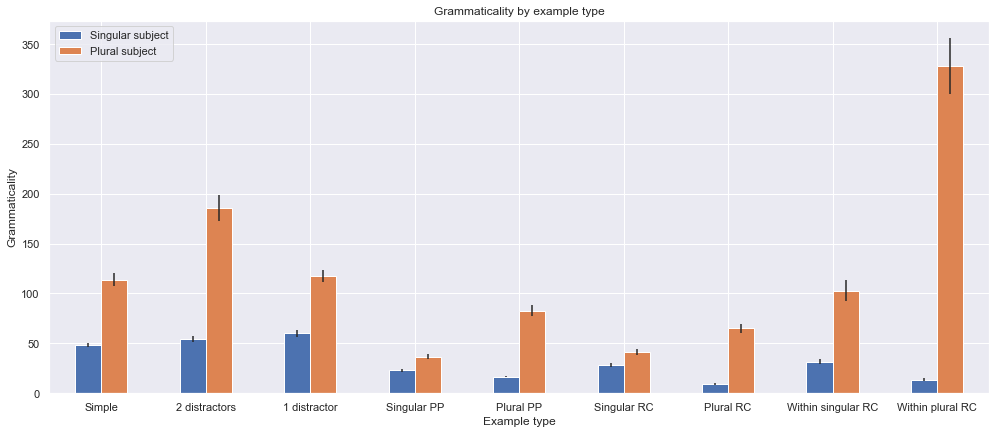

singular_grammaticality_mean  plural_grammaticality_mean
label                                                                       
Simple                                 34.335229                   69.899388
2 distractors                          29.774363                   94.751292
1 distractor                           30.277857                   67.291031
Singular PP                             7.951935                    9.950816
Plural PP                               9.714805                   31.141862
Singular RC                            10.001485                   11.303331
Plural RC                               3.250026                   15.920447
Within singular RC                     15.063508                   36.514720
Within plural RC                        3.641406                  126.074121

In [48]:
fig, ax = plt.subplots()
df = (
    pd.concat(dfs)
    .sort_index()
    .loc[0,0]
    .set_index('label')
    [[
        'inv_singular_grammaticality_mean','inv_plural_grammaticality_mean',
        'inv_singular_grammaticality_sem','inv_plural_grammaticality_sem'
    ]]
)
df[['inv_singular_grammaticality_mean','inv_plural_grammaticality_mean',]].plot.bar(
    figsize=(14, 6),
    rot=0,
    xlabel='Example type',
    ylabel='Grammaticality',
    yerr=df[['inv_singular_grammaticality_sem', 'inv_plural_grammaticality_sem']].values.T,
    ax=ax
)
ax.legend(['Singular subject', 'Plural subject'], loc='upper left')
plt.tight_layout()
plt.title('Grammaticality by example type')
plt.show()
plotit

- [x] Within rc
- [ ] Show size dim for TE and NIE and Grammaticality
    - [x] NIE
- [ ] Universally top neurons
- [ ] Heatmaps w/ normalized colors?

In [40]:
data['within_rc_plural_indirect_distilgpt2.feather']

word  \
Unnamed: 0                                              
0               The doctors that the {}_parent_avoids   
1               The doctors that the {}_parent_avoids   
2               The doctors that the {}_parent_avoids   
3               The doctors that the {}_parent_avoids   
4               The doctors that the {}_parent_avoids   
...                                               ...   
1075195     The lawyers that the {}_dancer_stimulates   
1075196     The lawyers that the {}_dancer_stimulates   
1075197     The lawyers that the {}_dancer_stimulates   
1075198     The lawyers that the {}_dancer_stimulates   
1075199     The lawyers that the {}_dancer_stimulates   

                            base_string                   alt_string1  \
Unnamed: 0                                                              
0           The doctors that the parent  The doctors that the parents   
1           The doctors that the parent  The doctors that the parents   
2           The doctors that the parent  The doctors that the parents   
3           The doctors that the parent  The doctors that the parents   
4           The doctors that the parent  The doctors that the parents   
...                                 ...                           ...   
1075195     The lawyers that the dancer  The lawyers that the dancers   
1075196     The lawyers that the dancer  The lawyers that the dancers   
1075197     The lawyers that the dancer  The lawyers that the dancers   
1075198     The lawyers that the dancer  The lawyers that the dancers   
1075199     The lawyers that the dancer  The lawyers that the dancers   

                 candidate1      candidate2  candidate1_base_prob  \
Unnamed: 0                                                          
0               ['Ġavoids']      ['Ġavoid']          2.969386e-05   
1               ['Ġavoids']      ['Ġavoid']          2.969386e-05   
2               ['Ġavoids']      ['Ġavoid']          2.969386e-05   
3               ['Ġavoids']      ['Ġavoid']          2.969386e-05   
4               ['Ġavoids']      ['Ġavoid']          2.969386e-05   
...                     ...             ...                   ...   
1075195     ['Ġstimulates']  ['Ġstimulate']          2.056094e-07   
1075196     ['Ġstimulates']  ['Ġstimulate']          2.056094e-07   
1075197     ['Ġstimulates']  ['Ġstimulate']          2.056094e-07   
1075198     ['Ġstimulates']  ['Ġstimulate']          2.056094e-07   
1075199     ['Ġstimulates']  ['Ġstimulate']          2.056094e-07   

            candidate2_base_prob  candidate1_alt1_prob  candidate2_alt1_prob  \
Unnamed: 0                                                                     
0                   2.581028e-05          2.571165e-07          8.697883e-05   
1                   2.581028e-05          2.571165e-07          8.697883e-05   
2                   2.581028e-05          2.571165e-07          8.697883e-05   
3                   2.581028e-05          2.571165e-07          8.697883e-05   
4                   2.581028e-05          2.571165e-07          8.697883e-05   
...                          ...                   ...                   ...   
1075195             2.103175e-08          4.198728e-09          3.306174e-07   
1075196             2.103175e-08          4.198728e-09          3.306174e-07   
1075197             2.103175e-08          4.198728e-09          3.306174e-07   
1075198             2.103175e-08          4.198728e-09          3.306174e-07   
1075199             2.103175e-08          4.198728e-09          3.306174e-07   

            candidate1_prob  candidate2_prob  layer  neuron  \
Unnamed: 0                                                    
0              2.926630e-05     2.597919e-05      0       0   
1              2.966997e-05     2.592030e-05      0       1   
2              2.978444e-05     2.579793e-05      0       2   
3              2.704677e-05     2.451090e-05      0       3   
4              2.909759e-05     2.573797